In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from pykalman import KalmanFilter

In [3]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')

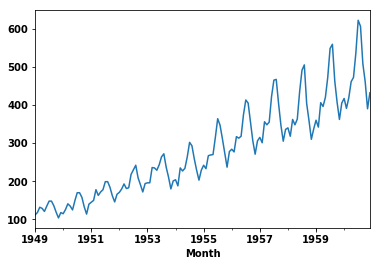

In [4]:
y.plot()

In [5]:
# 推移行列などの初期化
def FGHset(n_dim_trend, 
           n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series - 1
        start_col = n_dim_trend + n_dim_series - 1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [6]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12
# AR成分の次元数
n_dim_ar = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series, n_dim_ar)

In [7]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [8]:
# 前半120時点を学習データに121時点以降のデータを検証用に使用
n_train = 120
train, test = y.values[:n_train], y.values[n_train:]

In [9]:
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)

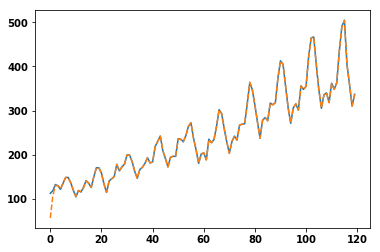

In [10]:
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

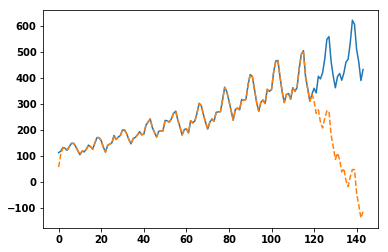

In [11]:
plt.plot(y.values, label="observation")

pred_y = np.empty(len(test))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
    
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

## ハイパーパラメタ最適化

In [12]:
from scipy.optimize import minimize
import copy


# parcorを用いたAR係数の推定
def ar_coef(parcor, n_dim_ar):
    ar_hat = np.zeros(n_dim_ar)
    am = np.zeros(n_dim_ar)
    if n_dim_ar==1:
        ar_hat = parcor
    else:
        for i in range(n_dim_ar):
            ar_hat[i] = parcor[i]
            am[i] = parcor[i]
            if i > 0:
                for j in range(i-1):
                    # m次のj番目の係数の算出
                    # am[j]はm-1次のj番目の係数
                    # am[i-j]はm-j次のm-j番目の係数
                    ar_hat[j] = am[j] - parcor[i] * am[i-j]
                if i < n_dim_ar-1:
                    for j in range(i-1):
                        am[j] = ar_hat[j]
    return ar_hat


# AR係数最適化のための対数尤度の計算
def ar_n_minimize_likelihood(target, kf, train, 
                             idx_target_parcor, st_row, st_col):
    kf.transition_matrices[st_row, st_col+idx_target_parcor] = target
    kf.smooth(train)

    # "masked arrays are not supported"というエラーが発生した場合は
    # https://github.com/pykalman/pykalman/issues/83
    # などを参照してPykalmanのコードを修正してほしい
    return -kf.loglikelihood(train)


# システムノイズの分散共分散行列最適化のための対数尤度の計算
def Q_minimize_likelihood(targets, kf, train, target_idx):
    for i, (r,c) in enumerate(target_idx):
        kf.transition_covariance[r, c] = targets[i]
    kf.smooth(train)
    return -kf.loglikelihood(train)


n_q = 2
# トレンド成分、季節成分、AR成分の分散の最適化の範囲
q_bnds = ((1e-4, 1e3),) * (n_q) + ((1e-4, 5e1),)
# AR成分の最適化の範囲
ar_bnds = ((-0.95, 0.95), )
# 行列GのAR成分成分の位置
st_row = n_dim_trend + n_dim_series - 1
st_col = n_dim_trend + n_dim_series - 1
# 最適化の繰り返し回数
n_iter = 2

# ハイパーパラメタ調整前のモデルを残すために
# オブジェクトをコピーしておく
q_kf = copy.deepcopy(kf)

# AR成分を個別に最適化
for idx_target_parcor in range(n_dim_ar):
    ar_idx_end = st_col + idx_target_parcor
    for i_opt in range(n_iter):
        if idx_target_parcor > 0:
            ar_args = q_kf.transition_matrices[st_row, 
                                               st_col:ar_idx_end]
            ar_cov = [q_kf.transition_covariance[st_row+i, st_col+i] 
                      for i in range(idx_target_parcor)]

        if i_opt==0:
            q_kf = copy.deepcopy(kf)
            
        if idx_target_parcor > 0:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end] = ar_args
            for i in range(idx_target_parcor):
                q_kf.transition_covariance[st_row+i, st_col+i] = ar_cov[i]

        args = (q_kf, train, idx_target_parcor, st_row, st_col)
        # 対象のparcorの係数の最適化
        minimize(ar_n_minimize_likelihood, 
                 (0.,), 
                 args=args, 
                 method='SLSQP', 
                 bounds=ar_bnds)

        q_args = (q_kf, train, [(st_row, st_col)])
        # AR成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood, 
                 (0., ), 
                 args=q_args, 
                 method='SLSQP', 
                 bounds=(q_bnds[2],))

        q_args = (q_kf, train, [(n_dim_trend, n_dim_trend)])
        # 季節成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[1],))

        q_args = (q_kf, train, [(0, 0)])
        # トレンド成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[0],))
        
        if idx_target_parcor==0:
            q_kf.transition_matrices[st_row, st_col] = \
                ar_coef(q_kf.transition_matrices[st_row, st_col], 1)
        else:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end+1] = \
                ar_coef(q_kf.transition_matrices[st_row,
                                                 st_col:ar_idx_end+1],
                        idx_target_parcor+1)

In [13]:
np.diag(q_kf.transition_covariance)

array([1.00014901e-04, 0.00000000e+00, 1.00000000e+03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.00000000e+01, 0.00000000e+00])

In [14]:
optmed_q_kf = copy.deepcopy(q_kf)

In [15]:
optm_smoothed_state_means, optm_smoothed_state_covs = optmed_q_kf.smooth(train)
optm_pred_o_smoothed = np.dot(optm_smoothed_state_means, 
                              optmed_q_kf.observation_matrices.T)

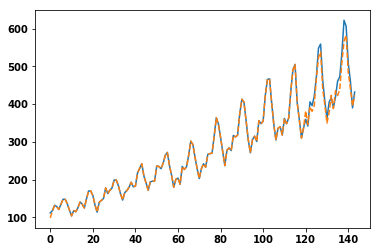

In [16]:
current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

pred_y = np.empty(len(test))
for i in range(len(test)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(y.values, label="observation")
plt.plot(np.hstack([optm_pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

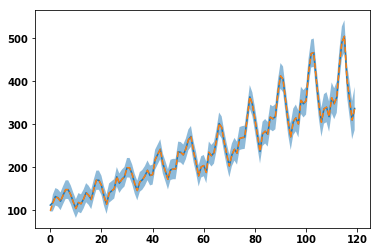

In [17]:
from scipy.stats import norm

# y_tの予測分布の分散
pred_cov = \
    optmed_q_kf.observation_matrices.dot(np.abs(optm_smoothed_state_covs)) \
                                    .transpose(1,0,2) \
                                    .dot(optmed_q_kf.observation_matrices.T)
# y_tの予測分布の平均
pred_mean = optm_smoothed_state_means.dot(optmed_q_kf.observation_matrices.T)
# 95%信用区間の上下限
lower, upper = norm.interval(0.95, 
                             pred_mean.flatten(), 
                             scale=np.sqrt(pred_cov.flatten()))

plt.plot(train, label="observation")
plt.plot(optm_pred_o_smoothed, '--', label="forecast")
plt.fill_between(range(len(train)), upper, lower,alpha=0.5, label="credible interval")

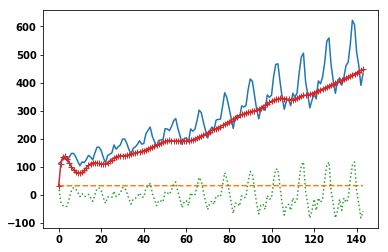

In [18]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series -1
# トレンド成分
t_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, :diff], 
                                optmed_q_kf.observation_matrices[:, :diff].T)
# 季節成分
s_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, diff:se], 
                                optmed_q_kf.observation_matrices[:, diff:se].T)
# AR成分
ar_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, se:], 
                                 optmed_q_kf.observation_matrices[:, se:].T)

current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

t_pred_y = np.empty(len(test))
s_pred_y = np.empty(len(test))
ar_pred_y = np.empty(len(test))
# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    t_pred_y[i] = optmed_q_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = optmed_q_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])
    ar_pred_y[i] = optmed_q_kf.observation_matrices[:, se:].dot(current_state[se:])

plt.plot(y.values, label="training data")
plt.plot(np.hstack([t_optm_pred_o_smoothed.flatten(), t_pred_y]), 
         '--', 
         label="predicted trend")
plt.plot(np.hstack([s_optm_pred_o_smoothed.flatten(), s_pred_y]), 
         ':', 
         label="predicted seasonal")
plt.plot(np.hstack([ar_optm_pred_o_smoothed.flatten(), ar_pred_y]), 
         '+-', 
         label="predicted ar")

In [19]:
np.diag(optmed_q_kf.transition_covariance)

array([1.00014901e-04, 0.00000000e+00, 1.00000000e+03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.00000000e+01, 0.00000000e+00])

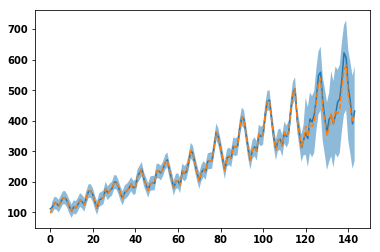

In [20]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series -1
# トレンド成分
t_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, :diff], 
                                optmed_q_kf.observation_matrices[:, :diff].T)
# 季節成分
s_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, diff:se], 
                                optmed_q_kf.observation_matrices[:, diff:se].T)
# AR成分
ar_optm_pred_o_smoothed = np.dot(optm_smoothed_state_means[:, se:], 
                                 optmed_q_kf.observation_matrices[:, se:].T)

current_state = optm_smoothed_state_means[-1]
current_cov = optm_smoothed_state_covs[-1]

# 訓練データ数
n_test = len(test)
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y = np.empty(n_test)
# 季節成分
s_pred_y = np.empty(n_test)
# AR成分
ar_pred_y = np.empty(len(test))
# 95%信用区間の下限
inf_lower = np.empty(n_test)
# 95%信用区間の上限
inf_upper = np.empty(n_test)
# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = optmed_q_kf.filter_update(current_state, 
                                                           current_cov, 
                                                           observation=None)
    t_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])
    ar_pred_y[i] = \
        optmed_q_kf.observation_matrices[:, se:].dot(current_state[se:])

    # y_tの予測分布の分散
    pred_cov = \
        optmed_q_kf.observation_matrices.dot(np.abs(current_cov)) \
                                        .dot(optmed_q_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(optmed_q_kf.observation_matrices.T)
    inf_lower[i], inf_upper[i] = norm.interval(0.95, 
                                               pred_mean, 
                                               scale=np.sqrt(pred_cov))
    
out = s_pred_y + t_pred_y + ar_pred_y

plt.plot(y.values, label="observation")
plt.plot(np.hstack([optm_pred_o_smoothed.flatten(), out]), '--', label="forecast")
all_lower = np.hstack([lower, inf_lower])
all_upper = np.hstack([upper, inf_upper])
plt.fill_between(range(len(y.values)), all_upper, all_lower, alpha=0.5, label="credible interval")